# Biomarker Evaluation on Multi-Omics Data

In [1]:
import pickle
import numpy as np
import pandas as pd

import networkx as nx

from scipy.stats import ttest_ind
from scipy.stats import rankdata

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

## 1. Drug Sensitivity Dataset

In [2]:
# potential hits for effectivity screening
drugs = pd.read_csv('../data/drugs.csv')
# set CCLE id as index
drugs = drugs.set_index(drugs.ccl_name)
# use the area under the drug sensitivity curve (AUC)
sensitivity = drugs.pivot_table(values='area_under_curve', index=drugs.index, columns='cpd_name', aggfunc='first')

## 2. Apply Clustering
Execute the clustering tasks based on the multi-omics profiles of the cells.

In [3]:
A = nx.read_gexf('../graphs/fused_affinity_network_K=20_alpha=0.1667_beta=0.1667_t=2.gexf')

In [4]:
sites = ['LUNG']

In [5]:
# select the lung cancer subgraph of the affinity network
selected_nodes = [n for n,v in A.nodes(data=True) if v['primary_site'] in sites]
H = A.subgraph(selected_nodes)

# create a sparse representation of the network by deleting edges
selected_edges = [(u,v) for u,v,e in H.edges(data=True) if e['weight'] >= 0.0]
G = H.edge_subgraph(selected_edges)

In [6]:
y = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
y = y[y.ccle_hist_subtype_1.isin(["adenocarcinoma", "small_cell_carcinoma"])]

In [59]:
from scipy.sparse import csr_matrix

W = nx.to_pandas_adjacency(G)
W = W[y.index.values].T[y.index.values]
X = csr_matrix(W, dtype=np.float64)

In [51]:
# load paramters for unsupervised k-means clustering algorithm
kmeans = pickle.load(open("../models/kmeans_carcinoma_AC-DC.joblib", 'rb'))
kmeans

KMeans(n_clusters=2, embedding_method=GSVD(n_components=2, regularization=None, factor_row=0.5, factor_col=0.5, factor_singular=0.0, normalized=False, solver=LanczosSVD(n_iter=None, tol=0.0)), co_cluster=False, sort_clusters=True, return_membership=True, return_aggregate=True)

In [39]:
X

<85x85 sparse matrix of type '<class 'numpy.float64'>'
	with 6977 stored elements in Compressed Sparse Row format>

In [52]:
# apply clustering from k-means model
y['multi-omics'] = kmeans.fit_transform(X)

In [ ]:
subtype = y.groupby(['ccle_hist_subtype_1'])['label'].apply(list)
clustering = y.groupby(['prediction'])['label'].apply(list)

## 3. Drug Screening

Use the t-test for statistical inference of two independent groups of samples. As a null hypotheses we assume that the expected sensitivity of all drugs is the same accross the two groups.

$$H_0: \mu_1 = \mu_2$$

In [21]:
resistant = sensitivity.loc[clustering.loc[0]]
sensitive = sensitivity.loc[clustering.loc[1]]

resistant = np.nan_to_num(resistant, nan=np.nanmean(resistant))
sensitive = np.nan_to_num(sensitive, nan=np.nanmean(sensitive))

In [12]:
resistant = sensitivity.loc[subtype.loc['adenocarcinoma']]
sensitive = sensitivity.loc[subtype.loc['small_cell_carcinoma']]

resistant = np.nan_to_num(resistant, nan=np.nanmean(resistant))
sensitive = np.nan_to_num(sensitive, nan=np.nanmean(sensitive))

In [13]:
# assume drug resistance for the first group
p_values = ttest_ind(a=resistant, b=sensitive, equal_var=False).pvalue
logfoldchange = np.log2(resistant.mean(axis=0)/sensitive.mean(axis=0))

Use the Benjamini-Hochberg procedure to correct for multi-hypothesis testing. The p-values will be adjusted with the false discovery rate (FDR) as follows.

$$q=min(R_j), j \geq i \ where \ R_i = \frac{p_i n}{i}$$

In [14]:
from scipy.stats import rankdata

# false-discovery rate (Benjamini-Hochberg)
ranked_p_values = rankdata(p_values)
adjusted = p_values * len(p_values) / ranked_p_values

adjusted[adjusted > 1] = 1

In [15]:
efficacy = pd.DataFrame({'cpd_name': sensitivity.columns.values, 'log2_fc': logfoldchange, 'p_value': p_values, 'q_adjusted':adjusted})
efficacy.head()

,cpd_name,log2_fc,p_value,q_adjusted
0,16-beta-bromoandrosterone,0.086354,0.003037,0.009044
1,"1S,3R-RSL-3",0.085398,0.525118,0.588866
2,3-Cl-AHPC,0.116526,0.021727,0.040691
3,968,0.066473,0.010826,0.022869
4,A-804598,0.057385,0.074920,0.114374


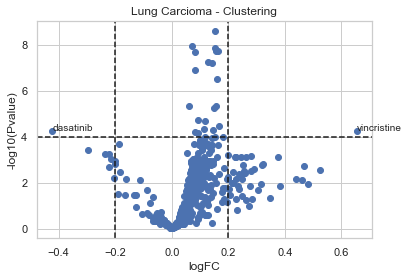

In [20]:
import warnings
warnings.filterwarnings('ignore')

plt.title('Lung Carcioma - Clustering')
plt.scatter(efficacy.log2_fc, -np.log10(efficacy.q_adjusted))

for i, label in enumerate(sensitivity.columns.values):
    if (((logfoldchange[i] > 0.4) | (logfoldchange[i] < -0.40)) & (-np.log10(efficacy.q_adjusted[i]) > 4)):
        plt.annotate(label, (efficacy.log2_fc[i], -np.log10(efficacy.q_adjusted[i])))

plt.axvline(x=0.2, color='k', linestyle='--')
plt.axvline(x=-0.2, color='k', linestyle='--')

plt.axhline(y=4, color='k', linestyle='--')

plt.ylabel('-log10(Pvalue)')
plt.xlabel('logFC')
plt.show()

## 4. Multi-Omics Biomarker

Design a biomarker from the fused multi-omics network.

In [12]:
clustering

prediction
0    [HCC827, NCIH1792, NCIH2228, CALU3, NCIH2023, ...
1    [NCIH510, NCIH889, NCIH1341, CORL279, NCIH524,...
Name: label, dtype: object

We use the Welch's t-test to compare the clusters, due to the unequal sample sizes of 45 to 31 cell lines.

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

metabolite_C2 vs. metabolite_C1: t-test independent samples, P_val:3.949e-02 t=2.102e+00
microrna_C2 vs. microrna_C1: t-test independent samples, P_val:1.152e-03 t=3.404e+00
gene_C2 vs. gene_C1: t-test independent samples, P_val:1.526e-02 t=2.493e+00
ground truth_SCLC vs. ground truth_AC: t-test independent samples, P_val:6.478e-05 t=4.276e+00
multi-omics_C2 vs. multi-omics_C1: t-test independent samples, P_val:6.686e-06 t=4.907e+00


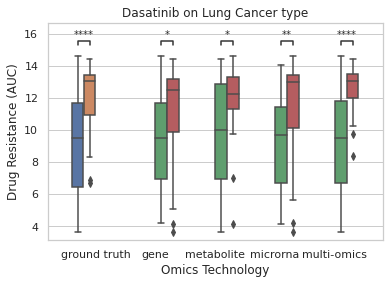

In [234]:
from statannotations.Annotator import Annotator

plt.title('Dasatinib on Lung Cancer type')

pairs=[(("ground truth", "AC"), ("ground truth", "SCLC")),(("gene", "C1"), ("gene", "C2")), (("metabolite", "C1"), ("metabolite", "C2")), (("microrna", "C1"), ("microrna", "C2")), (("multi-omics", "C1"), ("multi-omics", "C2"))]

ax = sns.boxplot(x="type",y="AUC",hue='prediction', hue_order=['AC','SCLC','C1','C2'], data=data)

annotator = Annotator(ax, pairs, data=data, x="type", hue="prediction", y="AUC")
annotator.configure(test='t-test_ind', test_short_name="", loc='inside')

plt.ylabel('Drug Resistance (AUC)')
plt.xlabel('Omics Technology')
annotator.apply_and_annotate()
plt.legend([],[], frameon=False)
#plt.savefig("../figures/dasatinib_lung_cancer_type.png", dpi=500, bbox_inches='tight')
plt.show()

Hence, we can compare the clusters on the individual and the fused omics-networks.